## Imports

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 # Used for image augmentation

# from fancyimpute import KNN # Used for imputing missing data
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import compute_class_weight
from sklearn.metrics import log_loss
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model


Using TensorFlow backend.


In [2]:
# Reproducible random seeds
seed = 6329
np.random.seed(3939)

## Data Pre-processing

In [3]:
# Load data
train = pd.read_json('train_imputed.json')
test = pd.read_json('test.json')

# Convert inc_angle to numeric
train['inc_angle'] = pd.to_numeric(train['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

In [4]:
# Number of training observations
print("There are {} observations in the training set.".format(len(train)))

There are 1604 observations in the training set.


In [5]:
# Observe data
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
10,"[-21.397552, -19.753859, -23.426783, -24.65221...","[-26.72291, -27.418192, -27.787899, -25.774536...",3aac67cd,44.6240,1
100,"[-20.04884, -19.469616, -20.510244, -19.61095,...","[-29.742329, -26.374287, -25.490265, -25.49031...",66348d03,41.1342,0
1000,"[-23.199345, -23.603487, -25.965549, -27.12546...","[-23.004148, -24.942425, -24.472878, -23.00437...",7052a617,33.8975,0


In [6]:
test.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [7]:
# Inspect rows for missing inc_angle values
trn_nangle_locs = train.loc[train['inc_angle'].isnull()].index
print("Found", len(trn_nangle_locs), "training observations with missing inc_angle data.")

Found 0 training observations with missing inc_angle data.


In [8]:
tst_nangle_locs = test.loc[test['inc_angle'].isnull()].index
print("Found", len(tst_nangle_locs), "testing observations with missing inc_angle data.")

Found 0 testing observations with missing inc_angle data.


In [9]:
# Fill in missing values using the fancyimpute package

# Make a copy of the training set
train_copy = train.copy()

# Make dataframes of pixel values for each band
band_1_df = pd.DataFrame(i for i in train_copy['band_1'])
band_2_df = pd.DataFrame(i for i in train_copy['band_2'])

# Combine to make dataframe for autocompletion
train_copy_df = pd.concat([band_1_df, band_2_df, train_copy['inc_angle']], axis=1)

# Retain column names before procesing
train_copy_df_cols = list(train_copy_df)

# Perform the K nearest neighbor imputation for the missing values
train_copy_df = pd.DataFrame(KNN(k=3).fit_transform(train_copy_df))

# Return column names to the dataframe
train_copy_df.columns = train_copy_df_cols


Imputing row 1/1604 with 0 missing, elapsed time: 154.505
Imputing row 101/1604 with 0 missing, elapsed time: 154.514
Imputing row 201/1604 with 0 missing, elapsed time: 154.520
Imputing row 301/1604 with 0 missing, elapsed time: 154.524
Imputing row 401/1604 with 0 missing, elapsed time: 154.528
Imputing row 501/1604 with 0 missing, elapsed time: 154.533
Imputing row 601/1604 with 0 missing, elapsed time: 154.536
Imputing row 701/1604 with 0 missing, elapsed time: 154.541
Imputing row 801/1604 with 0 missing, elapsed time: 154.546
Imputing row 901/1604 with 0 missing, elapsed time: 154.550
Imputing row 1001/1604 with 0 missing, elapsed time: 154.554
Imputing row 1101/1604 with 0 missing, elapsed time: 154.558
Imputing row 1201/1604 with 0 missing, elapsed time: 154.563
Imputing row 1301/1604 with 0 missing, elapsed time: 154.567
Imputing row 1401/1604 with 0 missing, elapsed time: 154.571
Imputing row 1501/1604 with 0 missing, elapsed time: 154.574
Imputing row 1601/1604 with 1 missin

In [10]:
# Put completed inc_angle values into original dataframe
train['inc_angle'] = train_copy_df['inc_angle']

# Confirm no values are missing
trn_nangle_locs = train.loc[train['inc_angle'].isnull()].index
print("Found", len(trn_nangle_locs), "training observations with missing inc_angle data after imputing.")


Found 0 training observations with missing inc_angle data after imputing.


In [7]:
# Rescale data for image classifier
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        #make 75x75 image
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 + band_2 # plus since log(x*y) = log(x) + log(y)
        
        # Rescale
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())

        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [9]:
# Generate training images and labels
Xtrain = get_scaled_imgs(train)
Ytrain = train['is_iceberg']

Xtest = get_scaled_imgs(test)

In [10]:
# Inspect image dimensions
Xtrain.shape[1:]

(75, 75, 3)

In [13]:
# Reshape band_1 data for visualisation
Xtrain_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])

## Data Visualisation

In [12]:
# Prepare for visualizations
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=400,
        height=400,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

ImportError: No module named 'plotly'

In [25]:
# Look at an iceberg
plotmy3d(Xtrain_band_1[5,:,:], 'Iceberg')

In [26]:
# Look at a ship
plotmy3d(Xtrain_band_1[17,:,:], 'Ship')

## Benchmark Model

In [18]:
def bmarkModel():
    
    # build keras model
    model = Sequential()
    
    # 1st conv. layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=Xtrain.shape[1:]))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    # 2nd conv. layer
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    # 3rd conv. layer
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    # 4th conv. layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.2))
    
    # flatten data for dense layers
    model.add(Flatten())

    # 1st dense layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 2nd dense layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    # output 
    model.add(Dense(1, activation="sigmoid"))

    optimizer = "adam"
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [24]:
# Capture benchmark model architecture
plot_model(bmark_model, to_file='model_arch/bmark_model.jpg', show_shapes=True, show_layer_names=True)

In [31]:
# Prepare the model
bmark_model = bmarkModel()
bmark_model.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
bmark_mcp_save = ModelCheckpoint('.bmark_mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 128)       147584    
__________

Train on 1203 samples, validate on 401 samples
Epoch 1/50
1203/1203 [==============================] - 2s - loss: 0.6721 - acc: 0.5702 - val_loss: 0.6251 - val_acc: 0.5686
Epoch 2/50
1203/1203 [==============================] - 1s - loss: 0.5874 - acc: 0.6617 - val_loss: 0.4298 - val_acc: 0.8055
Epoch 3/50
1203/1203 [==============================] - 1s - loss: 0.4426 - acc: 0.7872 - val_loss: 0.4359 - val_acc: 0.8155
Epoch 4/50
1203/1203 [==============================] - 1s - loss: 0.4098 - acc: 0.8063 - val_loss: 0.4713 - val_acc: 0.7531
Epoch 5/50
1203/1203 [==============================] - 1s - loss: 0.3549 - acc: 0.8487 - val_loss: 0.4331 - val_acc: 0.7805
Epoch 6/50
1203/1203 [==============================] - 1s - loss: 0.3145 - acc: 0.8579 - val_loss: 0.3304 - val_acc: 0.8653
Epoch 7/50
1203/1203 [==============================] - 1s - loss: 0.2672 - acc: 0.8828 - val_loss: 0.3109 - val_acc: 0.8678
Epoch 8/50
1203/1203 [==============================] - 1s - loss: 0.2313 - ac

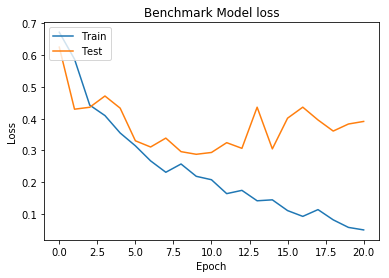

In [32]:
# Fit the model
history = bmark_model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=50, verbose=1, \
          callbacks=[earlyStopping, bmark_mcp_save, reduce_lr_loss], validation_split=0.25)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Benchmark Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
# Load best weights and score training data
bmark_model.load_weights(filepath = '.bmark_mdl_wts.hdf5')

score = bmark_model.evaluate(Xtrain, Ytrain, verbose=1)
print('Train score:', score[0])
print('Train accuracy:', score[1])

1604/1604 [==============================] - 0s     
Train score: 0.19445121436
Train accuracy: 0.934538653367


In [22]:
# Make predictions for test set
bmark_pred_test = bmark_model.predict(Xtest)

# Prepare submission
bmark_submission = pd.DataFrame({'id': test["id"], 'is_iceberg': bmark_pred_test.reshape((bmark_pred_test.shape[0]))})
print(bmark_submission.head(10))

# Export as csv
bmark_submission.to_csv('submissions/bmark_submission.csv', index=False)

         id  is_iceberg
0  5941774d    0.229695
1  4023181e    0.844483
2  b20200e4    0.038438
3  e7f018bb    0.989518
4  4371c8c3    0.889903
5  a8d9b1fd    0.188335
6  29e7727e    0.086252
7  92a51ffb    0.987180
8  c769ac97    0.000023
9  aee0547d    0.000101


## Solution Model

In [11]:
# Generate additional augmented images from existing data
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [12]:
# Generate extra training data
Xtr_more = get_more_images(Xtrain) 
Ytr_more = pd.concat([Ytrain, Ytrain, Ytrain], ignore_index=True)


# Estimate class weights since the dataset is unbalanced
class_weights = dict(zip([0, 1], compute_class_weight('balanced', [0, 1], Ytr_more)))

In [14]:
# Connect transfer learning network
def tlearnModel():
    
    base_model = VGG16(weights='imagenet', include_top=False,
                       input_shape=Xtrain.shape[1:], classes=1)
    
    x = base_model.get_layer('block5_pool').output
    
    x = GlobalMaxPooling2D()(x)
    #x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    predictions = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    adam = Adam(lr=1e-3, decay=0.0)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

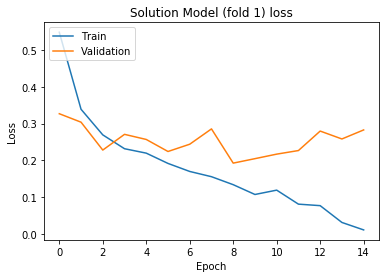


		FOLD 2 of 5

Train on 3849 samples, validate on 963 samples
Epoch 1/50
3849/3849 [==============================] - 47s - loss: 0.4704 - acc: 0.7605 - val_loss: 0.2740 - val_acc: 0.8785
Epoch 2/50
3849/3849 [==============================] - 46s - loss: 0.3120 - acc: 0.8631 - val_loss: 0.2324 - val_acc: 0.9107
Epoch 3/50
3849/3849 [==============================] - 46s - loss: 0.2532 - acc: 0.8935 - val_loss: 0.3867 - val_acc: 0.8723
Epoch 4/50
3849/3849 [==============================] - 46s - loss: 0.2279 - acc: 0.9041 - val_loss: 0.5348 - val_acc: 0.8120
Epoch 5/50
3849/3849 [==============================] - 47s - loss: 0.2008 - acc: 0.9148 - val_loss: 0.2353 - val_acc: 0.8920
Epoch 6/50
3849/3849 [==============================] - 47s - loss: 0.1786 - acc: 0.9306 - val_loss: 0.1786 - val_acc: 0.9283
Epoch 7/50
3849/3849 [==============================] - 47s - loss: 0.1798 - acc: 0.9301 - val_loss: 0.1916 - val_acc: 0.9242
Epoch 8/50
3849/3849 [==============================] -

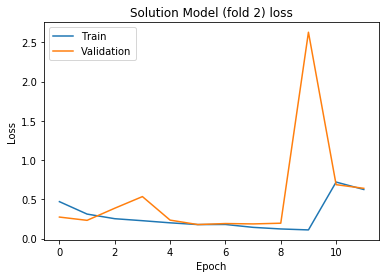


		FOLD 3 of 5

Train on 3849 samples, validate on 963 samples
Epoch 1/50
3849/3849 [==============================] - 47s - loss: 0.6283 - acc: 0.6118 - val_loss: 0.3913 - val_acc: 0.8297
Epoch 2/50
3849/3849 [==============================] - 47s - loss: 0.3627 - acc: 0.8350 - val_loss: 0.2798 - val_acc: 0.8795
Epoch 3/50
3849/3849 [==============================] - 47s - loss: 0.2773 - acc: 0.8826 - val_loss: 0.2411 - val_acc: 0.8910
Epoch 4/50
3849/3849 [==============================] - 47s - loss: 0.2356 - acc: 0.8989 - val_loss: 0.3686 - val_acc: 0.8744
Epoch 5/50
3849/3849 [==============================] - 47s - loss: 0.2061 - acc: 0.9208 - val_loss: 0.2108 - val_acc: 0.9180
Epoch 6/50
3849/3849 [==============================] - 47s - loss: 0.1916 - acc: 0.9239 - val_loss: 0.2336 - val_acc: 0.8982
Epoch 7/50
3849/3849 [==============================] - 47s - loss: 0.1605 - acc: 0.9376 - val_loss: 0.2277 - val_acc: 0.9013
Epoch 8/50
3849/3849 [==============================] -

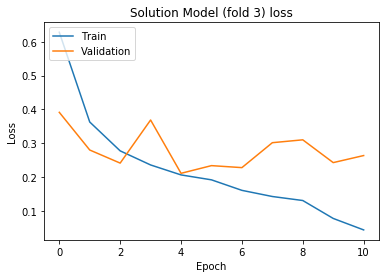


		FOLD 4 of 5

Train on 3850 samples, validate on 962 samples
Epoch 1/50
3850/3850 [==============================] - 47s - loss: 0.6267 - acc: 0.6218 - val_loss: 0.7059 - val_acc: 0.4699
Epoch 2/50
3850/3850 [==============================] - 47s - loss: 0.6682 - acc: 0.5722 - val_loss: 0.4698 - val_acc: 0.7796
Epoch 3/50
3850/3850 [==============================] - 47s - loss: 0.3924 - acc: 0.8317 - val_loss: 0.2682 - val_acc: 0.8649
Epoch 4/50
3850/3850 [==============================] - 47s - loss: 0.2938 - acc: 0.8756 - val_loss: 0.2571 - val_acc: 0.8784
Epoch 5/50
3850/3850 [==============================] - 47s - loss: 0.2644 - acc: 0.8896 - val_loss: 0.2609 - val_acc: 0.8794
Epoch 6/50
3850/3850 [==============================] - 47s - loss: 0.2271 - acc: 0.9073 - val_loss: 0.2403 - val_acc: 0.8919
Epoch 7/50
3850/3850 [==============================] - 47s - loss: 0.1978 - acc: 0.9226 - val_loss: 0.2566 - val_acc: 0.8950
Epoch 8/50
3850/3850 [==============================] -

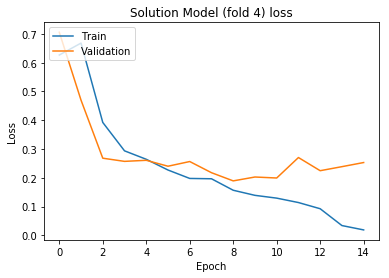


		FOLD 5 of 5

Train on 3851 samples, validate on 961 samples
Epoch 1/50
3851/3851 [==============================] - 47s - loss: 0.5636 - acc: 0.6832 - val_loss: 0.3466 - val_acc: 0.8325
Epoch 2/50
3851/3851 [==============================] - 47s - loss: 0.3430 - acc: 0.8403 - val_loss: 0.3211 - val_acc: 0.8085
Epoch 3/50
3851/3851 [==============================] - 47s - loss: 0.2833 - acc: 0.8746 - val_loss: 0.2520 - val_acc: 0.8678
Epoch 4/50
3851/3851 [==============================] - 47s - loss: 0.2442 - acc: 0.8967 - val_loss: 0.1935 - val_acc: 0.9220
Epoch 5/50
3851/3851 [==============================] - 47s - loss: 0.1992 - acc: 0.9159 - val_loss: 0.2147 - val_acc: 0.9105
Epoch 6/50
3851/3851 [==============================] - 47s - loss: 0.2067 - acc: 0.9156 - val_loss: 0.2577 - val_acc: 0.8793
Epoch 7/50
3851/3851 [==============================] - 47s - loss: 0.1704 - acc: 0.9327 - val_loss: 0.1884 - val_acc: 0.9209
Epoch 8/50
3851/3851 [==============================] -

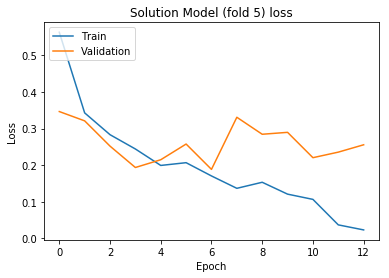


 Train Log Loss Validation=  0.11134004698
 Test Log Loss Validation=  0.138316424691


In [15]:
# Create train/test indices to split data in train/test sets
n_splits = 5
kfold = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(Xtr_more, Ytr_more))

# Assign model and summarise
model = tlearnModel()
model.summary()

batch_size = 8
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.tlearn_mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, epsilon=1e-4, mode='min')

# Initialise prediction stores
y_train_pred_log = 0
y_valid_pred_log = 0.0 * Ytr_more
true_test_predictions = 0

for f, (train_idx, test_idx) in enumerate(kfold):
    print('\n\t\tFOLD {} of {}\n'.format(f+1, n_splits))
    Xtrain_cv = Xtr_more[train_idx]
    Ytrain_cv = Ytr_more[train_idx]
    X_holdout = Xtr_more[test_idx]
    Y_holdout = Ytr_more[test_idx]
    
    # Define model
    model = tlearnModel()
    
    # Fit the model
    history = model.fit(Xtrain_cv, Ytrain_cv,
                        batch_size=batch_size,
                        epochs=50,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X_holdout, Y_holdout),
                        class_weight=class_weights,
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
    
    # Getting the Best Model
    model.load_weights(filepath='.tlearn_mdl_wts.hdf5')
    
    # Getting Training Score
    score = model.evaluate(Xtrain_cv, Ytrain_cv, verbose=0)
    print('Train loss:', score[0])
    print('Train accuracy:', score[1])
    # Getting Test Score
    score = model.evaluate(X_holdout, Y_holdout, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # Plot training & validation loss scores
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Solution Model (fold {}) loss'.format(f+1))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Getting Train Scores
    pred_train = model.predict(Xtr_more)
    y_train_pred_log += pred_train.reshape(pred_train.shape[0])
    
    # Getting validation Score
    pred_valid = model.predict(X_holdout)
    y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])
    
    # Predict True Test Score
    pred_test = model.predict(Xtest)
    true_test_predictions += pred_test.reshape(pred_test.shape[0])
    

true_test_predictions = true_test_predictions / n_splits
y_train_pred_log = y_train_pred_log / n_splits

print('\n Train Log Loss Validation= ', log_loss(Ytr_more, y_train_pred_log))
print(' Test Log Loss Validation= ', log_loss(Ytr_more, y_valid_pred_log))

In [16]:
# Generate dataframe of predictions for submission

tlearn_submission = pd.DataFrame({'id': test["id"], 'is_iceberg': true_test_predictions})

print(tlearn_submission.head(10))

tlearn_submission.to_csv('submissions/tlearn_submission.csv', index=False)

         id    is_iceberg
0  5941774d  2.612940e-02
1  4023181e  3.352387e-01
2  b20200e4  4.214705e-05
3  e7f018bb  9.998879e-01
4  4371c8c3  6.529006e-03
5  a8d9b1fd  4.838432e-01
6  29e7727e  5.869476e-03
7  92a51ffb  9.999809e-01
8  c769ac97  1.202260e-06
9  aee0547d  9.917236e-08


## Visualizations

In [17]:
# Normalize images for visualization
import matplotlib.image as mpimg

min1 = np.min(X_holdout)
max1 = np.max(X_holdout)
diff1 = max1 - min1
my_sum = lambda x: (x - min1)/diff1

X_holdout2 = my_sum(X_holdout)

In [18]:
# Get Indices for examples
Y_holdout

3       0
4       0
6       0
7       1
16      1
18      0
19      1
20      1
21      0
30      0
37      0
39      1
55      0
57      1
59      0
64      0
67      1
69      1
86      0
92      1
96      0
99      0
102     1
105     1
112     0
115     1
116     0
119     0
120     1
121     1
       ..
4681    1
4687    0
4696    1
4697    1
4698    0
4703    1
4708    0
4709    0
4713    1
4714    1
4718    1
4723    1
4725    0
4726    1
4732    1
4735    0
4745    0
4750    0
4759    0
4762    1
4766    1
4781    1
4782    0
4783    0
4784    1
4786    0
4793    1
4800    1
4804    1
4805    0
Name: is_iceberg, Length: 961, dtype: int64

Text(0.5,1,'Actual label: 0   Predicted Probability: [  1.70974729e-07]')

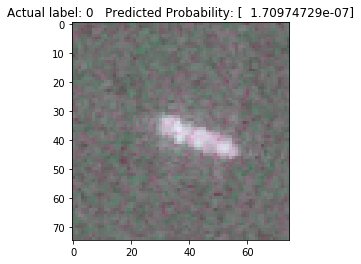

In [31]:
plt.imshow(X_holdout2[0], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[3]) + "   Predicted Probability: "+str(pred_valid[0])
plt.title(tl)

Text(0.5,1,'Actual label: 1   Predicted Probability: [ 0.99405527]')

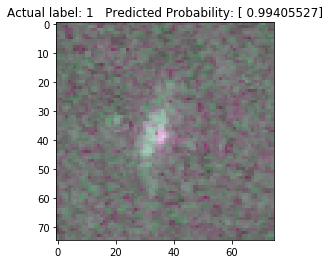

In [32]:
plt.imshow(X_holdout2[3], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[7]) + "   Predicted Probability: "+str(pred_valid[3])
plt.title(tl)

Text(0.5,1,'Actual label: 0   Predicted Probability: [ 0.02456363]')

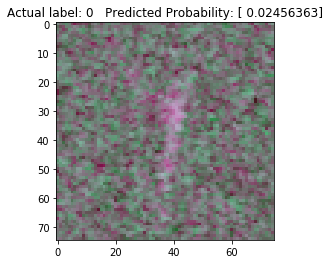

In [33]:
plt.imshow(X_holdout2[1], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[4]) + "   Predicted Probability: "+str(pred_valid[1])
plt.title(tl)

Text(0.5,1,'Actual label: 1   Predicted Probability: [ 0.99597293]')

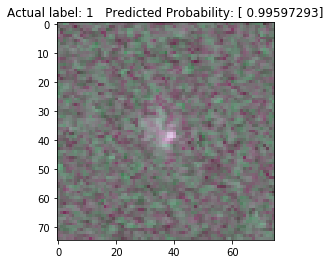

In [34]:
plt.imshow(X_holdout2[4], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[16]) + "   Predicted Probability: "+str(pred_valid[4])
plt.title(tl)

Text(0.5,1,'Actual label: 0   Predicted Probability: [  1.29612145e-05]')

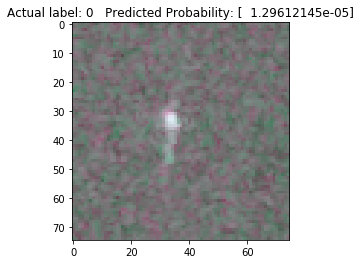

In [35]:
plt.imshow(X_holdout2[2], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[6]) + "   Predicted Probability: "+str(pred_valid[2])
plt.title(tl)

Text(0.5,1,'Actual label: 1   Predicted Probability: [ 0.99851507]')

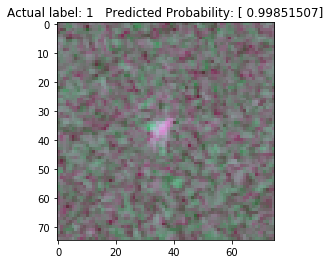

In [36]:
plt.imshow(X_holdout2[6], cmap='gray', interpolation='nearest');
tl = "Actual label: "+str(Y_holdout[19]) + "   Predicted Probability: "+str(pred_valid[6])
plt.title(tl)